In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-data/heart_disease_uci.csv


In [2]:
import pandas as pd
from IPython.display import display

# Загрузка данных из CSV файла
file_path = '/kaggle/input/heart-disease-data/heart_disease_uci.csv'
df = pd.read_csv(file_path)

# Вывод первых пяти строк в красивом формате
display(df.head())

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df.shape

(920, 16)

In [5]:
df.dtypes

id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
num           int64
dtype: object

In [6]:
#Five point summary for the numerical columns in the dataset

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


In [7]:
# Проверка на пустые ячейки
null_values = df.isnull().sum()

# Вывод количества пустых ячеек в каждом столбце
print(null_values)

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


# Избавляемся от пропущенных значений

In [8]:
# 3. to preprocess the data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# 4. to build the model:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# 5. for classification task:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# 6. Metrics:

from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score, f1_score , classification_report, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [9]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [10]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

In [11]:
# remove warning
import warnings
warnings.filterwarnings('ignore')

# all the columns having missing values:

missing_data_cols = df.columns[df.isnull().any()]

# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values trestbps : 6.41%
MAE = 13.034393063583813 

RMSE = 16.932271220085045 

R2 = 0.10482441259144526 

Missing Values chol : 3.26%
MAE = 45.275393258426966 

RMSE = 64.05804919205809 

R2 = 0.674938105037443 

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 79.52 accuracy

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 65.22 accuracy

Missing Values thalch : 5.98%
MAE = 16.61115606936416 

RMSE = 21.566689807398696 

R2 = 0.3236736665638945 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 80.35 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.5665348837209302 

RMSE = 0.7924548773009977 

R2 = 0.4017164923982385 

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 65.85 accuracy

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 62.9 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 73.56 accuracy



In [12]:
# Проверка на пустые ячейки
null_values = df.isnull().sum()

# Вывод количества пустых ячеек в каждом столбце
print(null_values)

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


# Важность признаков

## ANOVA

Влияние категориальным признаков на целевую переменную

Чем ниже p-value, тем больше влияния этого параметра на определение заболевания. То есть, наиболее значимые параметры: cp, thal и slope.

In [14]:
# Определяем категориальные и числовые признаки
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Преобразуем категориальные признаки в тип 'category', если необходимо
df[categorical_features] = df[categorical_features].astype('category')

# ANOVA для категориальных признаков
print("ANOVA для категориальных признаков:")
for cat_feature in categorical_features:
    # Группируем данные по категориальному признаку и извлекаем значения для переменной 'num'
    grouped_data = [group['num'].values for name, group in df.groupby(cat_feature)]
    
    # Выполняем ANOVA
    f_stat, p_value = f_oneway(*grouped_data)
    
    # Выводим результаты
    print(f"Признак: {cat_feature}")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")
    print("-" * 40)

# ANOVA для числовых признаков
print("\nANOVA для числовых признаков:")
for num_feature in numeric_features:
    # Разделяем значения числового признака на квантильные группы (например, на 4 группы)
    df['grouped_' + num_feature] = pd.qcut(df[num_feature], q=4, duplicates='drop')
    
    # Группируем данные по созданным квантильным группам
    grouped_data = [group['num'].values for name, group in df.groupby('grouped_' + num_feature)]
    
    # Выполняем ANOVA
    f_stat, p_value = f_oneway(*grouped_data)
    
    # Выводим результаты
    print(f"Признак: {num_feature}")
    print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4e}")
    print("-" * 40)

ANOVA для категориальных признаков:
Признак: sex
F-statistic: 66.1951, p-value: 1.3205e-15
----------------------------------------
Признак: cp
F-statistic: 76.5179, p-value: 3.5902e-44
----------------------------------------
Признак: fbs
F-statistic: 15.6672, p-value: 8.1354e-05
----------------------------------------
Признак: restecg
F-statistic: 14.0618, p-value: 9.6560e-07
----------------------------------------
Признак: exang
F-statistic: 158.1003, p-value: 1.4406e-33
----------------------------------------
Признак: slope
F-statistic: 90.9982, p-value: 8.9033e-37
----------------------------------------
Признак: thal
F-statistic: 98.0280, p-value: 2.6198e-39
----------------------------------------

ANOVA для числовых признаков:
Признак: age
F-statistic: 44.0363, p-value: 1.3764e-26
----------------------------------------
Признак: trestbps
F-statistic: 10.5828, p-value: 7.6125e-07
----------------------------------------
Признак: chol
F-statistic: 26.1566, p-value: 3.0789e-16

## CORRELATION

Наиболее значимые числовые параметры - ca, oldpeak, age

In [17]:
# Определяем числовые и категориальные признаки
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Создаем новый DataFrame с числовыми признаками
selected_df = df[numeric_features]

# Рассчитываем средние значения числовых признаков, сгруппированных по num
numeric_influence_means = selected_df.groupby('num').mean()

# Рассчитываем средние значения num для категориальных признаков
categorical_influence_means = {}
for cat_feature in categorical_features:
    if cat_feature in df.columns:  # Проверяем, существует ли категориальный признак
        categorical_influence_means[cat_feature] = df.groupby(cat_feature)['num'].mean()
    else:
        print(f"Категориальный признак '{cat_feature}' не найден в данных.")

# Рассчитываем корреляцию только для исходных параметров
correlation_with_num = selected_df.corr()['num'].drop('num')

# Рассчитываем корреляцию категориальных признаков с num
categorical_correlations = {}
for cat_feature in categorical_features:
    if cat_feature in df.columns:  # Проверяем, существует ли категориальный признак
        categorical_correlations[cat_feature] = df[cat_feature].astype('category').cat.codes.corr(df['num'])

# Выводим результаты
print("\nСредние значения числовых признаков, сгруппированных по num:")
print(numeric_influence_means)

print("\nСредние значения num для категориальных признаков:")
for cat_feature, means in categorical_influence_means.items():
    print(f"\nКатегориальный признак '{cat_feature}':")
    print(means)

print("\nКорреляция категориальных признаков с num:")
for cat_feature, correlation in categorical_correlations.items():
    print(f"{cat_feature}: {correlation}")

print("\nКорреляция числовых признаков с num:")
print(correlation_with_num)



Средние значения числовых признаков, сгруппированных по num:
           age    trestbps        chol      thalch   oldpeak        ca
num                                                                   
0    50.547445  130.199002  227.891898  147.777591  0.493579  0.111922
1    53.528302  133.084868  197.390868  130.598755  1.061551  0.377358
2    57.577982  133.918073  145.981835  128.373394  1.410275  1.036697
3    59.214953  136.250654  160.436168  120.791121  1.748710  1.420561
4    59.214286  139.420000  193.783929  127.139643  2.362071  1.357143

Средние значения num для категориальных признаков:

Категориальный признак 'sex':
sex
Female    0.42268
Male      1.14876
Name: num, dtype: float64

Категориальный признак 'cp':
cp
asymptomatic       1.443548
atypical angina    0.183908
non-anginal        0.661765
typical angina     0.717391
Name: num, dtype: float64

Категориальный признак 'fbs':
fbs
False    0.933504
True     1.347826
Name: num, dtype: float64

Категориальный признак 

Наиболее значимые числовые параметры - ca, oldpeak и age

Наиболее значимые категориальные параметры - exang,sex и tal

## РСА

In [18]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Определяем категориальные и числовые признаки
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']

# Преобразуем категориальные признаки в числовые с помощью One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Выбираем только интересующие признаки
selected_features = numeric_features
X = df_encoded[selected_features]

# Стандартизируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Применяем PCA для сокращения размерности
pca = PCA(n_components=6)  # Указываем желаемое количество компонент
X_pca = pca.fit_transform(X_scaled)

# Рассчитываем важность признаков
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance_PCA': pca.components_[0]  # Важность по первой главной компоненте
})

# Сортируем по важности
feature_importance = feature_importance.sort_values(by='Importance_PCA', ascending=False)

# Фильтруем только оригинальные признаки
feature_importance = feature_importance[feature_importance['Feature'].isin(numeric_features)]

# Выводим важность признаков
print("Важность исходных признаков по первой главной компоненте:")
print(feature_importance)

# Выводим долю объясненной дисперсии для каждой главной компоненты
print("\nДоля объясненной дисперсии для каждой главной компоненты:")
for i, variance in enumerate(pca.explained_variance_ratio_):
    print(f"Главная компонента {i + 1}: {variance:.4f}")


Важность исходных признаков по первой главной компоненте:
    Feature  Importance_PCA
6       num        0.501084
5        ca        0.460757
0       age        0.438804
4   oldpeak        0.380937
1  trestbps        0.197259
2      chol       -0.162289
3    thalch       -0.365659

Доля объясненной дисперсии для каждой главной компоненты:
Главная компонента 1: 0.3659
Главная компонента 2: 0.1700
Главная компонента 3: 0.1355
Главная компонента 4: 0.1035
Главная компонента 5: 0.1007
Главная компонента 6: 0.0778


Наиболее значимые числовые параметры - ca,age, oldpeak

In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Определяем категориальные признаки
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Преобразуем категориальные признаки в числовые с помощью Label Encoding (для совместного анализа категорий)
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# Выбираем только категориальные признаки
X_categorical = df[categorical_features]

# Стандартизируем данные
scaler = StandardScaler()
X_categorical_scaled = scaler.fit_transform(X_categorical)

# Применяем PCA для сокращения размерности
pca_categorical = PCA(n_components=min(X_categorical.shape[1], X_categorical.shape[0]))
X_categorical_pca = pca_categorical.fit_transform(X_categorical_scaled)

# Рассчитываем важность признаков
categorical_importance = pd.DataFrame({
    'Feature': categorical_features,
    'Importance_PCA': pca_categorical.components_[0]  # Важность по первой главной компоненте
})

# Сортируем по важности
categorical_importance = categorical_importance.sort_values(by='Importance_PCA', ascending=False)

# Выводим важность признаков
print("Важность категориальных признаков по первой главной компоненте:")
print(categorical_importance)

# Выводим долю объясненной дисперсии для каждой главной компоненты
print("\nДоля объясненной дисперсии для каждой главной компоненты:")
for i, variance in enumerate(pca_categorical.explained_variance_ratio_):
    print(f"Главная компонента {i + 1}: {variance:.4f}")


Важность категориальных признаков по первой главной компоненте:
   Feature  Importance_PCA
4    exang        0.533711
6     thal        0.437057
0      sex        0.336947
3  restecg        0.195063
2      fbs        0.143857
1       cp       -0.391257
5    slope       -0.445842

Доля объясненной дисперсии для каждой главной компоненты:
Главная компонента 1: 0.2893
Главная компонента 2: 0.1490
Главная компонента 3: 0.1394
Главная компонента 4: 0.1302
Главная компонента 5: 0.1120
Главная компонента 6: 0.1033
Главная компонента 7: 0.0768


Наиболее значимые категориальные параметры - thal, slope и cp

## XGBoost

Категориальные признаки - thal, slope, exang

Числовые признаки - ca, thalch, oldpeak

In [21]:
# Список категориальных признаков
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
# Список числовых признаков
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num']

In [22]:
# Выбираем только нужные признаки
selected_df = df[categorical_features + numeric_features + ['num']]  # Добавляем LUNG_CANCER

# Применяем One-Hot Encoding к категориальным признакам
selected_df = pd.get_dummies(selected_df, columns=categorical_features, drop_first=True)

# Убедимся, что LUNG_CANCER остался после One-Hot Encoding
if 'num' not in selected_df.columns:
    selected_df['num'] = df['num']

# Создаем новые столбцы для средних значений
selected_df['avg_sex'] = selected_df.filter(like='sex_').mean(axis=1)
selected_df['avg_cp'] = selected_df.filter(like='cp_').mean(axis=1)
selected_df['avg_fbs'] = selected_df.filter(like='fbs_').mean(axis=1)
selected_df['avg_restecg'] = selected_df.filter(like='restecg_').mean(axis=1)
selected_df['avg_exang'] = selected_df.filter(like='exang_').mean(axis=1)
selected_df['avg_slope'] = selected_df.filter(like='slope_').mean(axis=1)
selected_df['avg_thal'] = selected_df.filter(like='thal_').mean(axis=1)

# Выбираем только интересующие признаки, включая средние значения
selected_features = ['num', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca','avg_sex', 'avg_cp', 'avg_fbs', 'avg_restecg','avg_exang', 'avg_slope', 'avg_thal']
selected_df = selected_df[selected_features]

# Отделяем целевую переменную
X = selected_df.drop('num', axis=1)
y = selected_df['num']

In [23]:
import xgboost as xgb

# Создаем модель XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, y)

# Получаем важности признаков
feature_importances_xgb = xgb_model.feature_importances_

# Создаем DataFrame с важностью признаков
feature_importance_df_xgb = pd.DataFrame({'Feature': X.columns, 'Importance_XGB': feature_importances_xgb})

# Сортируем признаки по важности
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance_XGB', ascending=False)

# Выводим результаты
print("Важность признаков на основе XGBoost:")
print(feature_importance_df_xgb)

Важность признаков на основе XGBoost:
        Feature  Importance_XGB
5            ca        0.475645
10    avg_exang        0.186259
7        avg_cp        0.070169
6       avg_sex        0.050996
4       oldpeak        0.049177
12     avg_thal        0.025926
3        thalch        0.025018
11    avg_slope        0.023533
9   avg_restecg        0.023318
2          chol        0.019320
8       avg_fbs        0.018062
0           age        0.017274
1      trestbps        0.015303


## Random Forest

Важность числовых признаков с помощью Random Forest:
    Feature  Importance
3    thalch    0.144903
2      chol    0.130489
0       age    0.127462
4   oldpeak    0.125568
1  trestbps    0.121615
5        ca    0.109322

Важность категориальных признаков с помощью Random Forest:
        Feature  Importance
7        avg_cp    0.075744
10    avg_exang    0.050788
6       avg_sex    0.030250
9   avg_restecg    0.025557
12     avg_thal    0.021650
8       avg_fbs    0.019612
11    avg_slope    0.017039


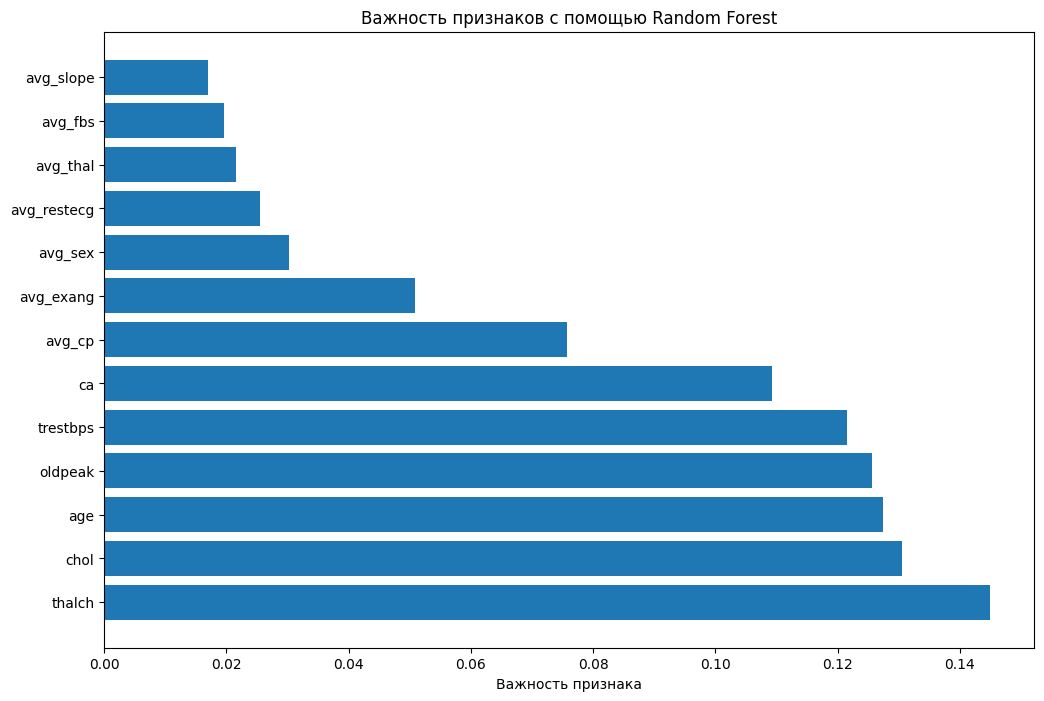

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем модель Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Получаем важность признаков
importance = rf_model.feature_importances_

# Создаем DataFrame с важностью признаков
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Сортируем DataFrame по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Разделяем важность признаков на числовые и категориальные
numeric_importance = importance_df[importance_df['Feature'].isin(numeric_features)]
categorical_importance = importance_df[~importance_df['Feature'].isin(numeric_features)]

# Выводим важность признаков
print("Важность числовых признаков с помощью Random Forest:")
print(numeric_importance)

print("\nВажность категориальных признаков с помощью Random Forest:")
# Здесь заменяем закодированные категориальные признаки на исходные
categorical_importance['Feature'] = categorical_importance['Feature'].str.replace('_True', '').str.replace('sex_Male', 'sex').str.replace('sex_Female', 'sex')
print(categorical_importance)

# Для визуализации важности признаков можно использовать метод plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Важность признака')
plt.title('Важность признаков с помощью Random Forest')
plt.show()


Категориальные признаки - thal, slope, exang

Числовые признаки - ca, thalch, age

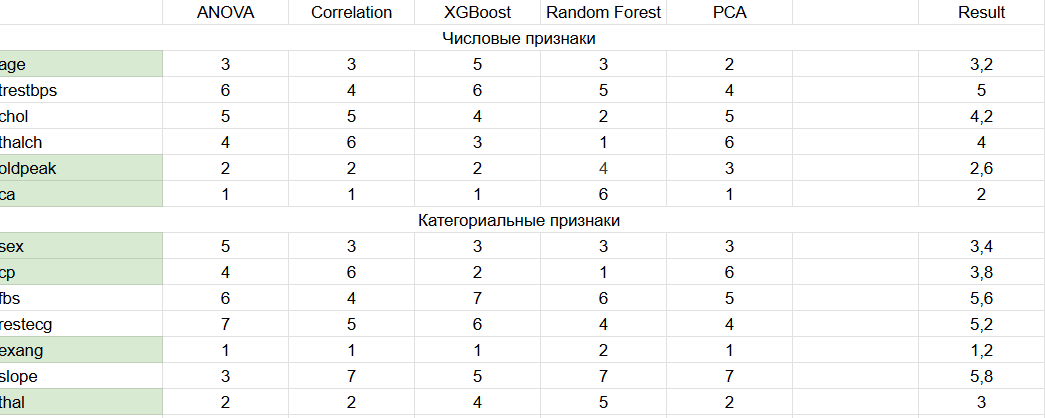
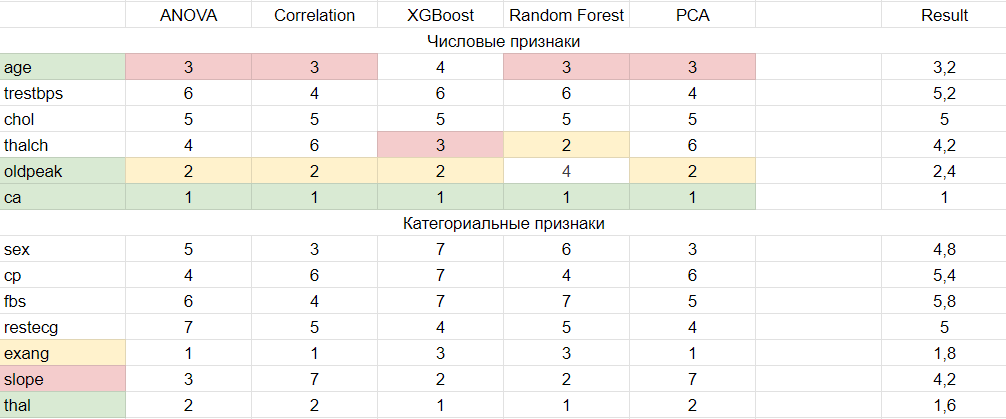